<h2> Imports </h2>

In [1]:
from ngboost import NGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ngboost.distns import Exponential, Normal
from scipy.stats import burr
from ngboost.scores import LogScore, CRPScore
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr, spearmanr
import math
from scipy import stats
import fitter
from scipy.spatial import distance
import properscoring as ps
import warnings
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics.cluster import normalized_mutual_info_score
warnings.filterwarnings("ignore")

In [2]:
# !pip install seaborn
# !pip install fitter
# !pip install properscoring
# !pip install shap

<h2> Helper Methods </h2>

In [3]:
## Generate lags for all input features, re-generate even if some exist so that order will not be shuffled after nan dropping
def generate_lags_for(df, column, lags_count):
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

    
def get_accurate_prediction_score(y_test, y_pred):
    ratio = np.abs(y_test - y_pred) / y_test
    return ratio

def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, X_test, Y_train, Y_test


#calculates all error metrics needed
def calculate_errors(y_test, y_pred, nb_columns):
    n = len(y_test)
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test, y_pred)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    pearson_corr, _ = pearsonr(np.array(y_test).ravel(), np.array(y_pred).ravel())
    spearman_corr, _ = spearmanr(np.array(y_test).ravel(), np.array(y_pred).ravel())
    distance_corr = distance.correlation(np.array(y_test).ravel(), np.array(y_pred).ravel())
    acc = 100 - mape_score
    nmi = normalized_mutual_info_score(np.array(y_test).ravel(), np.array(y_pred).ravel())
    aic = n * np.log(mse_score)
    bic = n * np.log(mse_score)
    print('\nRegression Error Metrics')
    print('R2: %.5f' % r2_Score)
    print('Adj-R2: %.5f' % adjusted_r2)
    print('RMSE: %.5f' % rmse_score)
    print('MSE: %.5f' % mse_score)
    print('MAE: %.5f' % mae_score)
    print('MAPE: %.5f' % mape_score)
    print('Accuracy: %.5f' % acc)
    print('\nCorrelations')
    print('Pearson: %.5f' % pearson_corr)
    print('Spearman: %.5f' % spearman_corr)
    print('Distance: %.5f' % distance_corr)
    
    print('\nExtra')
    print('NMI: %.5f' % nmi)
    print('AIC: %.5f' % aic)
    print('BIC: %.5f' % bic)
    
    
def gen_xspan(mean, std, n=2, num=100):
#Generate span for x axis to plot the probabilty distribution
    return np.linspace(mean - n * std, mean + n * std, num)

def normalize_ticks(ax):
    cln_ticks = lambda t: float(t.replace("−", "-"))
    get_ticks = lambda ax: list(
        map(cln_ticks, [item.get_text() for item in ax.get_yticklabels()])
    )
    labels = get_ticks(ax)
    labels = [f"{l / np.max(labels):.3f}" for l in labels]
    ax.set_yticklabels(labels)
    return ax

def heavyside(thresholds, actual):
    # Given a deterministic observation, make a CDF out of it
    result = [1 if t >= actual else 0 for t in thresholds]
    return result

def is_cdf_valid(case):
    if case[0] < 0 or case[0] > 1:
        return False
    for i in xrange(1, len(case)):
        if case[i] > 1 or case[i] < case[i-1]:
            return False
    return True

def calc_crps(thresholds, predictions, actuals):
    nthresh = len(thresholds)  # 70 in example
    ncases  = len(predictions)
    crps = 0
    for case, actual in zip(predictions, actuals):
        if (len(case) == nthresh) and is_cdf_valid(case):
            obscdf = heavyside(thresholds, actual)
            for fprob, oprob in zip(case, obscdf):
                crps = crps + (fprob - oprob)*(fprob - oprob)
        else:
            crps = crps + nthresh  # treat delta at each threshold as 1
    crps = crps / float(ncases * nthresh)

<h2> Read Data</h2>

In [4]:
input_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(input_path, delimiter=',')
output_column ='LE_bowen_corr_mm'
df.head()

,Date,Site,Year,Month,Day,Climate,Vegetation,Latitude,Longitude,Site_1,...,Eeflux_NDVI-2,Eeflux_NDVI-3,Eeflux_NDVI-4,Eeflux_NDVI-5,Eeflux_Albedo,Eeflux_Albedo-1,Eeflux_Albedo-2,Eeflux_Albedo-3,Eeflux_Albedo-4,Eeflux_Albedo-5
0,3/8/2000,FI-Jok,2000,3,8,Other,CRO,60.8986,23.51345,1,...,NaN,NaN,NaN,NaN,0.581,NaN,NaN,NaN,NaN,NaN
1,3/9/2000,FI-Jok,2000,3,9,Other,CRO,60.8986,23.51345,1,...,NaN,NaN,NaN,NaN,0.559,0.581,NaN,NaN,NaN,NaN
2,3/11/2000,FI-Jok,2000,3,11,Other,CRO,60.8986,23.51345,1,...,0.003,NaN,NaN,NaN,0.557,0.559,0.581,NaN,NaN,NaN
3,3/12/2000,FI-Jok,2000,3,12,Other,CRO,60.8986,23.51345,1,...,-0.034,0.003,NaN,NaN,0.555,0.557,0.559,0.581,NaN,NaN
4,3/15/2000,FI-Jok,2000,3,15,Other,CRO,60.8986,23.51345,1,...,-0.025,-0.034,0.003,NaN,0.540,0.555,0.557,0.559,0.581,NaN


<h2> Drop Columns </h2>

In [5]:
columnsToDrop = ['Date','Year','Month','Day','Latitude','Longitude',
                'Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)', 'ET_bowen_corr_mm', 'ETo', 'Climate'
                ]    

<h2> Data Preprocessing </h2>

In [6]:
#drop na
df.dropna(inplace=True)

#set output variable between 1 and 15 only
df = df[df[output_column].between(1, 15)]

#drop desired columns, rename, and drop the nans
df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

#generate lags for columns
lagsForColumns = ["WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI", "SW_IN"]
df = generate_lags(df, lagsForColumns)

#drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)
print("checking null values in the whole dataset")
print(df.isnull().values.any())
print(df.columns)
#df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
#df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
df.dropna(inplace=True)


(5123, 51)
checking null values in the whole dataset
False
Index(['Site', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr_mm', 'Eeflux_LST',
       'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3', 'Eeflux_LST-4',
       'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1', 'Eeflux_NDVI-2',
       'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5', 'Eeflux_Albedo',
       'Eeflux_Albedo-1', 'Eeflux_Albedo-2', 'Eeflux_Albedo-3',
       'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')


In [7]:
print(np.array(df['LE_bowen_corr_mm']).mean())

3.8792617744331452


<h2> Split Data </h2>

In [8]:
#split into train and test according to special split
X_train, X_test, Y_train, Y_test = split_train_test_valid(df, 0.8, 0.2)

X_train = X_train.drop('Site', axis = 1)
X_test = X_test.drop('Site', axis = 1)
X_train.columns

Number of sites: 24


Index(['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
       'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2',
       'Eeflux_LST-3', 'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI',
       'Eeflux_NDVI-1', 'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4',
       'Eeflux_NDVI-5', 'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')

<h2> Altering Xtra Trees Parameters </h2>

NGBoost can be used with a variety of distributions, broken down into those for regression (support on an infinite set).
Regression distributions can be used through the NGBRegressor() constructor by passing the appropriate class as the Dist argument. Normal is the default.

NGBoost supports the log score (LogScore, also known as negative log-likelihood) and CRPS (CRPScore), although each score may not be implemented for each distribution. The score is specified by the Score argument in the constructor.

NGBoost can be used with any sklearn regressor as the base learner, specified with the Base argument. The default is a depth-3 regression tree.

In [9]:
model = ExtraTreesRegressor(n_estimators =100).fit(X_train, Y_train)

Point Prediction

In [13]:
Y_pred = model.predict(X_test)

<h2> Feature Importance </h2> 



We caution users against trying to interpret too much from any machine learning model, but NGBoost does provide methods to interpret models fit with regression tree base learners. Since each parameter in the distribution is fit by a separate sequence of learners, there will be multiple model interpretation results, one for each parameter. The default distribution used is Normal so the following example shows results for the loc and scale parameters.
Feature Importance


<h2> SHAP </h2>

Get Shap values

In [14]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)

In [15]:
X_train.columns

Index(['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
       'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2',
       'Eeflux_LST-3', 'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI',
       'Eeflux_NDVI-1', 'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4',
       'Eeflux_NDVI-5', 'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')

OR the Categorical Columns

In [16]:
X_test_new = X_test 
X_test_new['Month_encoded'] = np.logical_or(X_test_new['Month_1'], X_test_new['Month_2'])
X_test_new['Month_encoded'] = np.logical_or(X_test_new['Month_encoded'], X_test_new['Month_3'])
X_test_new['Month_encoded'] = np.logical_or(X_test_new['Month_encoded'], X_test_new['Month_4'])

In [17]:
X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site_1'], X_test_new['Site_2'])
X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site_encoded'], X_test_new['Site_3'])
X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site_encoded'], X_test_new['Site_4'])
X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site_encoded'], X_test_new['Site_5'])
X_test_new['Site_encoded'] = np.logical_or(X_test_new['Site_encoded'], X_test_new['Site_6'])

In [18]:
X_test_new['Vegt_encoded'] = np.logical_or(X_test_new['Vegetation_1'], X_test_new['Vegetation_2'])
X_test_new['Vegt_encoded'] = np.logical_or(X_test_new['Vegt_encoded'], X_test_new['Vegetation_3'])

Drop original encoded columns

In [19]:
X_test_new = X_test_new.drop(['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5',
                'Site_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
                'Vegetation_2', 'Vegetation_3'], axis = 1)

In [20]:
X_test_new['Site_encoded'] = X_test_new['Site_encoded'].astype(int)
X_test_new['Vegt_encoded'] = X_test_new['Vegt_encoded'].astype(int)
X_test_new['Month_encoded'] = X_test_new['Month_encoded'].astype(int)

Reorder columns

In [21]:
cols = ['Site_encoded', 'Month_encoded', 'Vegt_encoded', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2',
       'Eeflux_LST-3', 'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI',
       'Eeflux_NDVI-1', 'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4',
       'Eeflux_NDVI-5', 'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5']

X_test_new = X_test_new[cols]

In [22]:
X_test_new.shape

(1033, 39)

Sum up SHAP values

In [23]:
shap_values = explainer.shap_values(X_test)
shap_values.shape

(1033, 52)

In [24]:
shap_values_new = np.empty(shape=[1033, 39])
shap_values_new[:,0] = shap_values[:,0] +  shap_values[:,1] + shap_values[:,2] +  shap_values[:,3] + shap_values[:,4] +  shap_values[:,5] 
shap_values_new[:,1] = shap_values[:,6] +  shap_values[:,7] + shap_values[:,8] + shap_values[:,9]
shap_values_new[:,2] = shap_values[:,10] +  shap_values[:,11] + shap_values[:,12]

In [25]:
i = 3
j = 13
while i < shap_values_new.shape[1]:
    print(i)
    shap_values_new[:,i] = shap_values[:,j]
    i = i+1
    j = j+1

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


# Getting Accurate Predictions

In [26]:
#extract indices with error % not more than 10%
index = []
for i in range(len(Y_test)):
    score = get_accurate_prediction_score(np.array(Y_test)[i], np.array(Y_pred)[i])
    print(score)
    if score <= 0.1:
        index.append(i)

[0.66016814]
[0.72000281]
[0.4727857]
[0.2321745]
[0.59345317]
[0.26116563]
[0.06192276]
[0.18786726]
[0.18834555]
[0.15007866]
[0.08666495]
[0.27650395]
[0.1160428]
[0.08489444]
[0.12475777]
[0.25376801]
[0.1623196]
[0.119629]
[0.41572411]
[0.34372092]
[0.01052415]
[0.56265156]
[0.5494527]
[0.22183842]
[0.45928344]
[0.25979641]
[0.15758281]
[0.00361258]
[0.09064831]
[0.03376972]
[0.19686588]
[0.1359463]
[0.26863722]
[0.00073212]
[0.06107452]
[0.78400262]
[0.01627641]
[0.14118301]
[0.17656365]
[0.23946594]
[0.03664977]
[0.00239756]
[0.067483]
[0.00662535]
[0.10458208]
[0.06413146]
[0.19064013]
[0.00549504]
[0.08143374]
[0.18578582]
[0.19486886]
[0.58394814]
[0.21318901]
[1.17692959]
[0.55665406]
[0.62123076]
[0.4487644]
[0.53482582]
[0.23508342]
[0.29414744]
[0.31693618]
[0.02514972]
[0.43929667]
[0.5638909]
[0.26822075]
[0.14590119]
[0.59051252]
[0.56836741]
[0.45851238]
[0.97204737]
[0.19766301]
[0.6748101]
[0.69540712]
[0.53479176]
[0.15605813]
[0.08772937]
[0.21345433]
[1.01125089]

[0.32540787]
[0.25274392]
[0.19219222]
[0.2100657]
[0.39763281]
[0.548539]
[0.54819271]
[0.2964152]
[0.23587115]
[0.00713829]
[0.25518412]
[0.25424114]
[0.05699742]
[0.14770724]
[0.10277613]
[0.22287643]
[0.04380508]
[0.23600403]
[0.21661744]
[0.29947077]
[0.15045471]
[0.01958011]
[0.23081501]
[0.29181369]
[0.25629465]
[0.01010302]
[0.38959209]
[0.16540475]
[0.22868982]
[0.06627567]
[0.16095429]
[0.35632067]
[0.26353757]
[0.37533379]
[0.10538642]
[0.12156767]
[0.09606534]
[0.04582729]
[0.11692962]
[0.09655347]
[0.15587938]
[0.39837038]
[0.0615163]
[0.05653635]
[0.63291237]
[0.38279512]
[0.12324261]
[0.21981049]
[0.29692909]
[0.25208254]
[0.34883999]
[0.03850172]
[0.28715445]
[0.21445599]
[0.21541521]
[0.06336645]
[0.29220074]
[0.30954823]
[0.49811978]
[0.53266635]
[0.07714403]
[0.17027186]
[0.14623316]
[0.1518512]
[0.03722602]
[0.03958803]
[0.05417253]
[0.57686588]
[0.47758158]
[0.30029831]
[0.34987587]
[0.45782267]
[0.13373244]
[0.04789148]
[0.34243175]
[0.5870044]
[0.3250316]
[0.3216

In [27]:
#subsetting dataset to get only the accurate predictions
X_test_accurate = X_test_new
X_test_accurate = X_test_accurate[X_test_accurate.index.isin(index)]

In [28]:
shap_values_accurate = shap_values_new
shap_values_accurate = shap_values_accurate[index]
len(shap_values_accurate)

257

# SHAP Plot

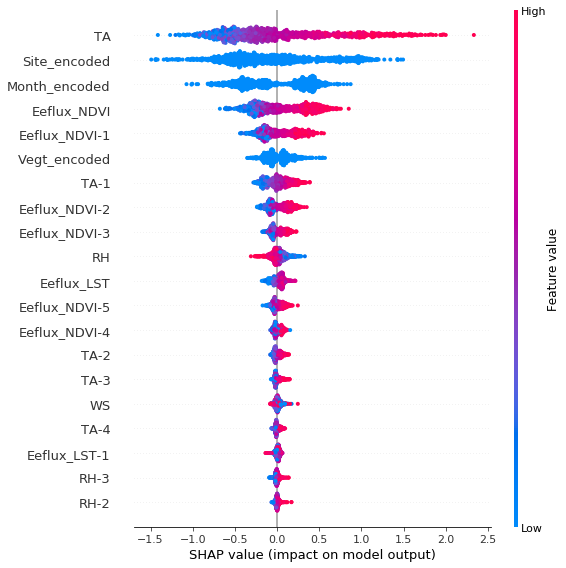

In [30]:
## SHAP plot for loc trees
shap.summary_plot(shap_values_new, X_test_new, feature_names=X_test_new.columns)

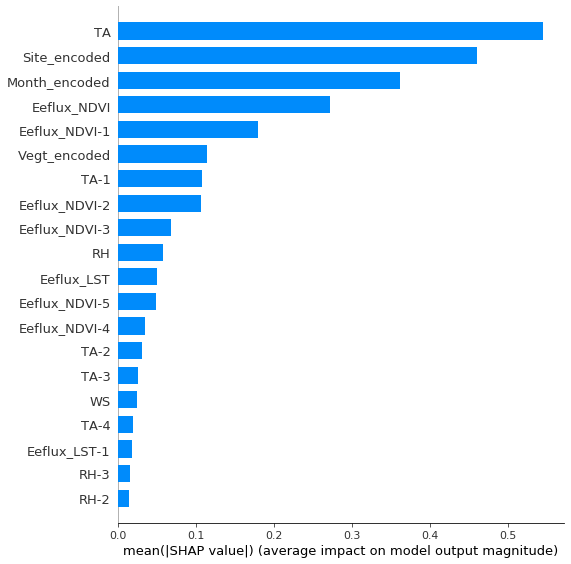

In [31]:
shap.summary_plot(shap_values_new, X_test_new, plot_type='bar')

SHAP Force Plot on Rare Values in Testing Data 

In [32]:
X_test_rare = pd.DataFrame()
shap_rare = []
for i in range(len(X_test_new)):
    X_test_i = X_test_new.iloc[i,:]
    if(Y_test.iloc[i,:]['LE_bowen_corr_mm'] > 4):
        X_test_rare = X_test_rare.append(X_test_i)
        shap_rare.append(shap_values_new[i])

The output value is the prediction for that observation (the prediction for this observation is 1.73).

The base value: The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat). 

Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

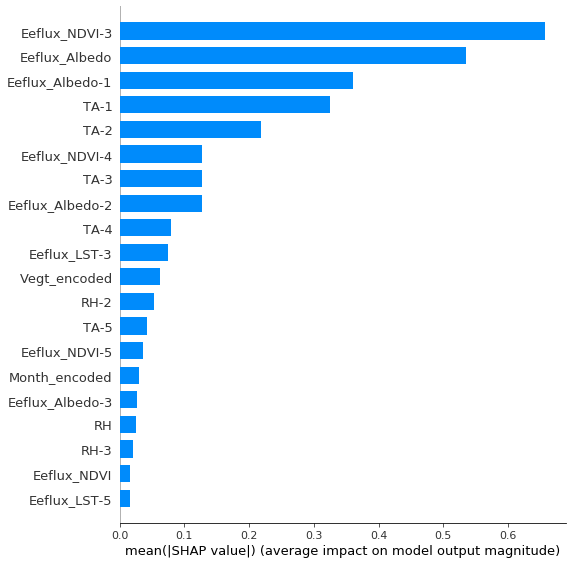

In [33]:
shap.summary_plot(np.array(shap_rare), X_test_rare, plot_type='bar')

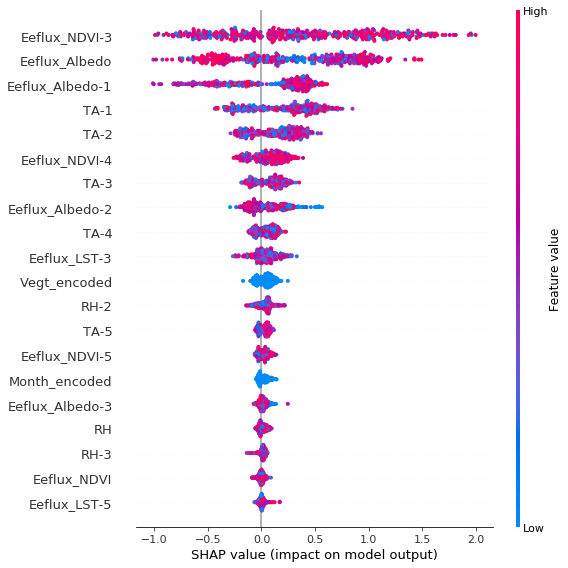

In [34]:
shap.summary_plot(np.array(shap_rare), X_test_rare, feature_names=X_test_rare.columns)

SHAP Force Plot on Regular Values in Testing Data 

In [35]:
X_test_notrare = pd.DataFrame()
shap_notrare = []
for i in range(len(X_test_new)):
    X_test_i = X_test_new.iloc[i,:]
    if(Y_test.iloc[i,:]['LE_bowen_corr_mm'] < 5):
        X_test_notrare = X_test_notrare.append(X_test_i)
        shap_notrare.append(shap_values_new[i])

Dependency Plots

In [36]:
shap_values.shape

(1033, 52)

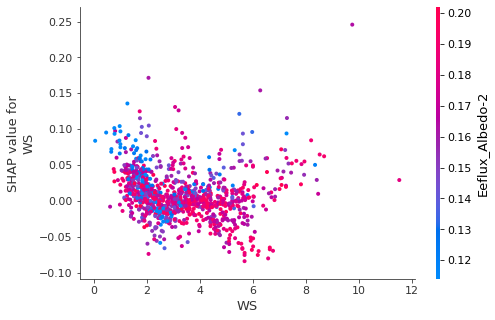

In [37]:
import matplotlib
shap.dependence_plot('WS', np.array(shap_values_new), X_test_new)

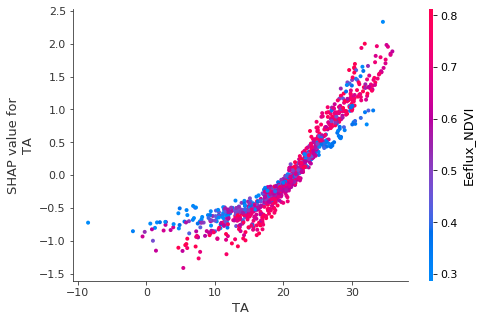

In [38]:
shap.dependence_plot('TA', np.array(shap_values_new), X_test_new)

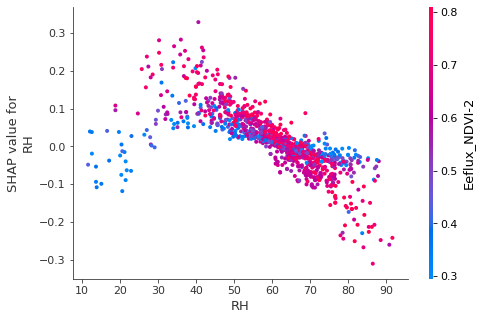

In [39]:
shap.dependence_plot('RH', np.array(shap_values_new), X_test_new)

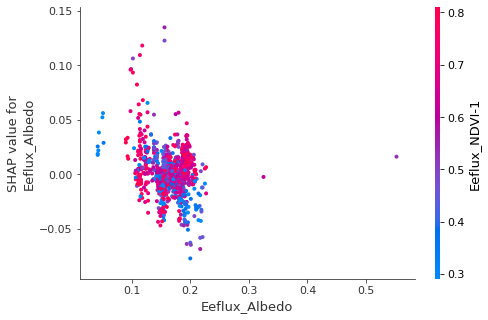

In [40]:
shap.dependence_plot('Eeflux_Albedo', np.array(shap_values_new), X_test_new)

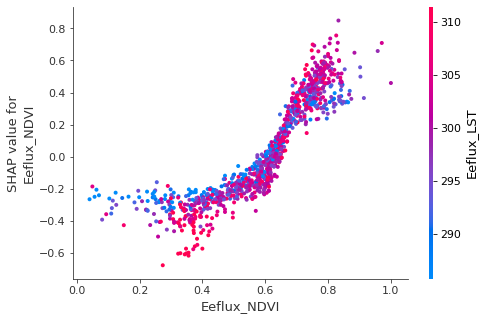

In [41]:
shap.dependence_plot('Eeflux_NDVI',np.array(shap_values_new), X_test_new)

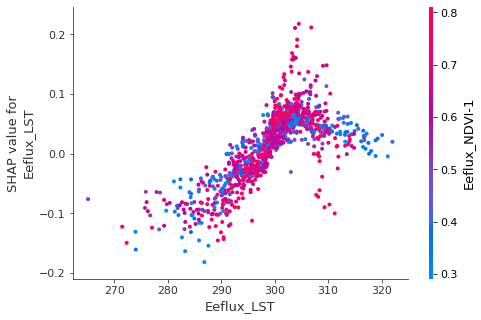

In [42]:
shap.dependence_plot('Eeflux_LST',np.array(shap_values_new), X_test_new)

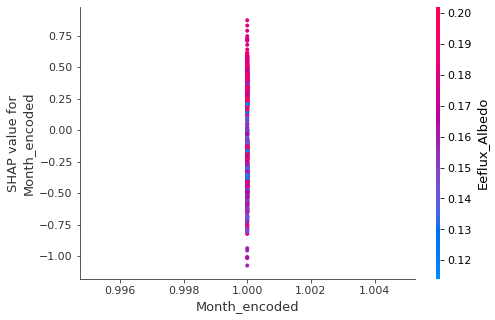

In [43]:
shap.dependence_plot('Month_encoded',np.array(shap_values_new), X_test_new)

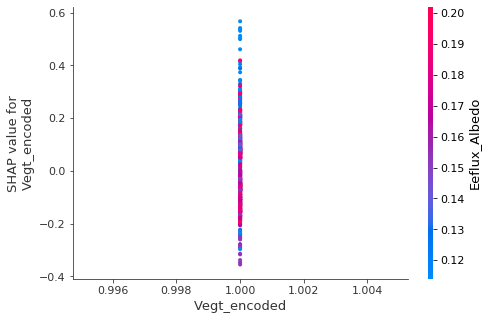

In [44]:
shap.dependence_plot('Vegt_encoded',np.array(shap_values_new), X_test_new)

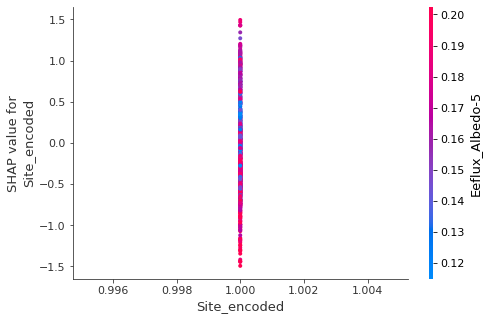

In [45]:
shap.dependence_plot('Site_encoded',np.array(shap_values_new), X_test_new)

On Rare Values

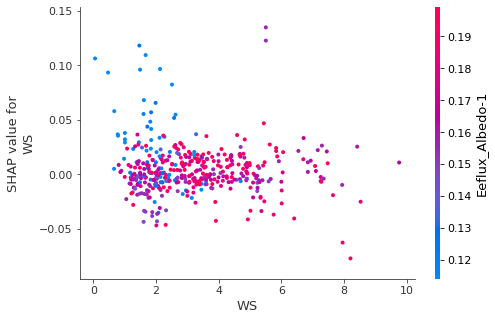

In [46]:
import matplotlib
shap.dependence_plot('WS', np.array(shap_rare), X_test_rare)

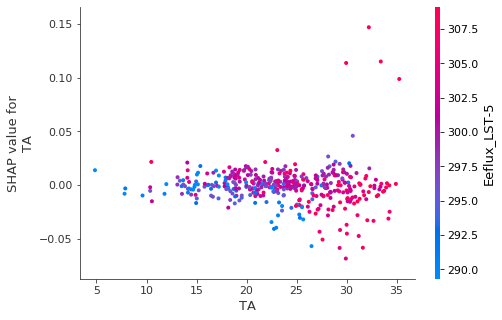

In [47]:
shap.dependence_plot('TA', np.array(shap_rare), X_test_rare)

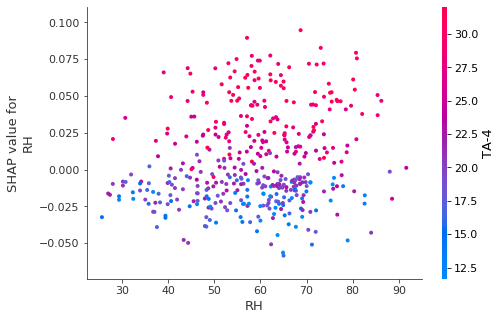

In [48]:
shap.dependence_plot('RH', np.array(shap_rare), X_test_rare)

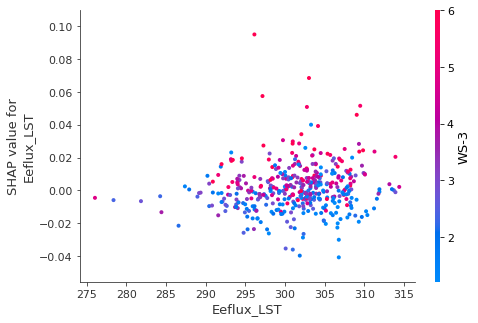

In [49]:
shap.dependence_plot('Eeflux_LST', np.array(shap_rare), X_test_rare)

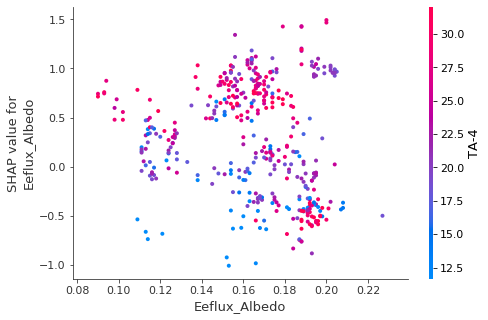

In [50]:
shap.dependence_plot('Eeflux_Albedo', np.array(shap_rare), X_test_rare)

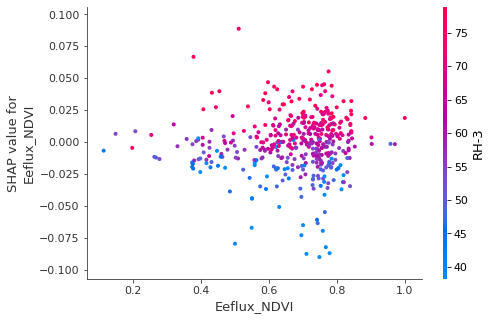

In [51]:
shap.dependence_plot('Eeflux_NDVI', np.array(shap_rare), X_test_rare)

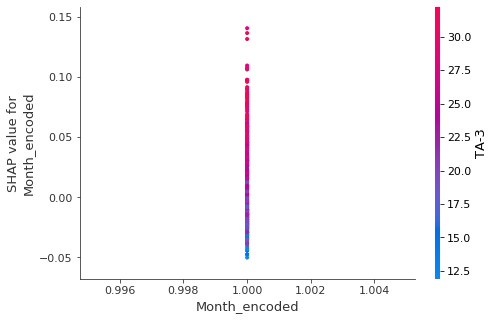

In [52]:
shap.dependence_plot('Month_encoded', np.array(shap_rare), X_test_rare)

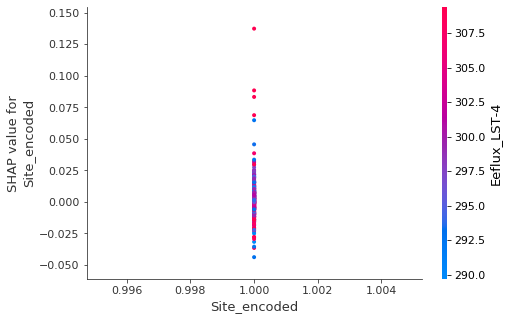

In [53]:
shap.dependence_plot('Site_encoded', np.array(shap_rare), X_test_rare)

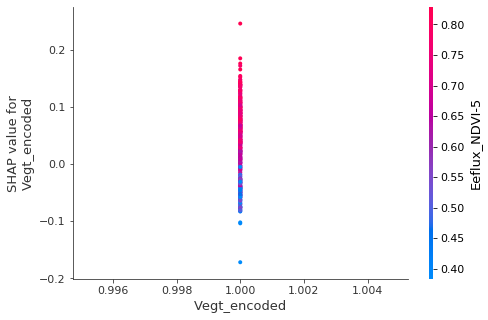

In [54]:
shap.dependence_plot('Vegt_encoded', np.array(shap_rare), X_test_rare)

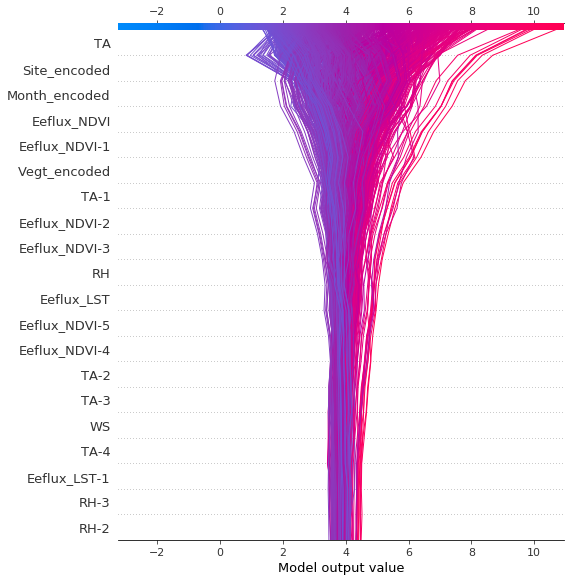

In [55]:
shap.decision_plot(explainer.expected_value, np.array(shap_values_new), np.array(X_test_new), feature_names=list(X_test_new.columns))

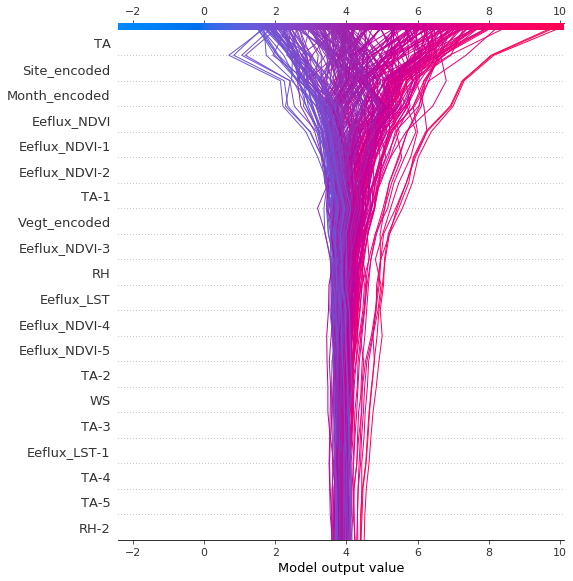

In [29]:
shap.decision_plot(explainer.expected_value, np.array(shap_values_accurate), np.array(X_test_accurate), feature_names=list(X_test_new.columns))

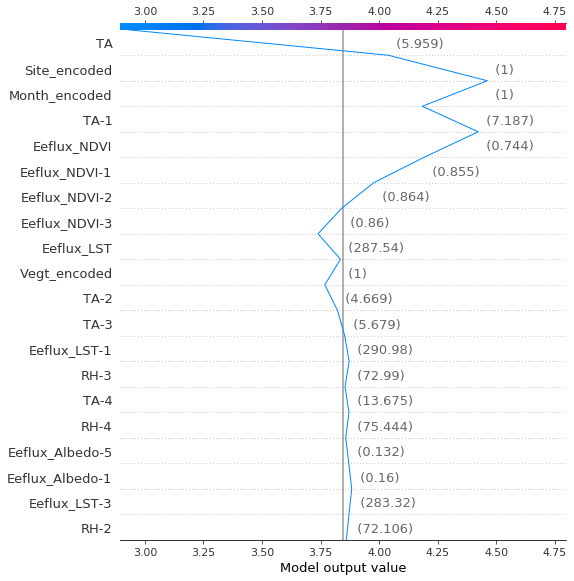

In [56]:
shap.decision_plot(explainer.expected_value, np.array(shap_values_new)[34,:], np.array(X_test_new)[34,:], feature_names=list(X_test_new.columns))